Importing necessary libraries

In [ ]:
from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter("my_dir")
import torch
import numpy as np
import torchaudio
import torch.nn as nn
import matplotlib.pyplot as plt
import pandas as pd
import librosa
from torch.utils.data import Dataset, DataLoader
from torchsummary import summary
import torchaudio.transforms as T
from sklearn.decomposition import PCA
!pip install captum
from captum.attr import (
    GradientShap,
    DeepLift,
    DeepLiftShap,
    IntegratedGradients,
    LayerConductance,
    NeuronConductance,
    NoiseTunnel,
)

device = "cuda" if torch.cuda.is_available() else "cpu"
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 39.9 MB/s eta 0:00:00
Mounted at /content/drive


Creating visualization functions for the audio

In [ ]:
def plot_spectrogram(spec, title=None, ylabel='freq_bin', aspect='auto', xmax=None):
  fig, axs = plt.subplots(1, 1)
  axs.set_title(title or 'Spectrogram (db)')
  axs.set_ylabel(ylabel)
  axs.set_xlabel('frame')
  im = axs.imshow(librosa.power_to_db(spec), origin='lower', aspect=aspect)
  if xmax:
    axs.set_xlim((0, xmax))
  fig.colorbar(im, ax=axs)
  plt.show(block=False)
  plt.show()

def plot_pitch(waveform, sample_rate, pitch):
  figure, axis = plt.subplots(1, 1)
  axis.set_title("Pitch Feature")
  axis.grid(True)

  end_time = waveform.shape[1] / sample_rate
  time_axis = torch.linspace(0, end_time,  waveform.shape[1])
  axis.plot(time_axis, waveform[0], linewidth=1, color='gray', alpha=0.3)

  axis2 = axis.twinx()
  time_axis = torch.linspace(0, end_time, pitch.shape[1])
  ln2 = axis2.plot(
      time_axis, pitch[0], linewidth=2, label='Pitch', color='green')

  axis2.legend(loc=0)
  plt.show(block=False)
  plt.show()

Initializes data modules for the audio to be preprocessed

Initializing model architecture

In [ ]:
from torch import nn
from torchsummary import summary
from torch.autograd import Variable

class CNNNetwork(nn.Module):

    def __init__(self):
        super().__init__()
        # 4 conv blocks / flatten / linear / softmax
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.flatten = nn.Flatten()
        self.linear = nn.Linear(21120, 1)

    def forward(self, input_data):
        x = self.conv1(input_data)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.flatten(x)
        logits = self.linear(x)
        return logits

class RNNNetwork (nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
        super(RNNNetwork, self).__init__()
        self.num_classes = num_classes #number of classes
        self.num_layers = num_layers #number of layers
        self.input_size = input_size #input size
        self.hidden_size = hidden_size #hidden state
        self.seq_length = seq_length #sequence length

        self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
        self.fc_1 =  nn.Linear(hidden_size, 128) #fully connected 1
        self.fc = nn.Linear(128, num_classes) #fully connected last layer

        self.relu = nn.ReLU()
    
    def forward(self,x):
        h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #hidden state
        c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).to(device) #internal state
        # Propagate input through LSTM
        output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
        hn = hn.view(-1, self.hidden_size) #reshaping the data for Dense layer next
        out = self.relu(hn)
        out = self.fc_1(out) #first Dense
        out = self.relu(out) #relu
        out = self.fc(out) #Final Output
        return out
 

class CRNN(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super().__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
    self.fc1 = nn.Linear(660, num_classes) #fully connected last layer

    self.relu = nn.ReLU()

  def forward(self, x):
            #print(x.shape)
            x = self.conv1(x)
            #print(x.shape)
            x = self.conv2(x)
            #print(x.shape)
            x = self.conv3(x)
            #print(x.shape)
            x = self.conv4(x)
            #print(x.shape)
            x = x.transpose(1, -1)
            #print(x.shape)
            batch, time = x.size()[:2]
            x = x.reshape(batch, time, -1)
            h_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() #hidden state
            c_0 = Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda() #internal state
           # Propagate input through LSTM
            #print(x.shape)
            output, (hn, cn) = self.lstm(x, (h_0, c_0)) #lstm with input, hidden, and internal state
            #print(output.shape)
            hn = torch.reshape(output, (output.size(0), -1))
            #print(hn.shape)
            x = self.relu(hn)
            #print(x.shape)
            x = self.fc1(x)
            #print(x.shape)
            return x

class MergeCRNN(nn.Module):
  def __init__(self, num_classes, input_size, hidden_size, num_layers, seq_length):
    super().__init__()
    self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=1,
                out_channels=16,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=16,
                out_channels=32,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=32,
                out_channels=64,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=64,
                out_channels=128,
                kernel_size=3,
                stride=1,
                padding=2
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
    )
    self.num_classes = num_classes #number of classes
    self.num_layers = num_layers #number of layers
    self.input_size = input_size #input size
    self.hidden_size = hidden_size #hidden state
    self.seq_length = seq_length #sequence length

    self.lstm = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                          num_layers=num_layers, batch_first=True) #lstm
    self.fc1 = nn.Linear(660, num_classes) #fully connected last layer

    self.relu = nn.ReLU()

  def forward(self, x):
            #print(x.shape)
            conv_output = self.conv1(x)
            #print(x.shape)
            conv_output = self.conv2(conv_output)
            #print(x.shape)
            conv_output = self.conv3(conv_output)
            #print(x.shape)
            conv_output = self.conv4(conv_output)
            conv_output = conv_output.transpose(1, -1)
            batch, time = x.size()[:2]
            lstm_output = x.reshape(batch, time, -1)
            print(lstm_output.shape)
            h_0 = Variable(torch.zeros(self.num_layers, lstm_output.size(0), self.hidden_size)).cuda() #hidden state
            c_0 = Variable(torch.zeros(self.num_layers, lstm_output.size(0), self.hidden_size)).cuda() #internal state
           # Propagate input through LSTM
            #print(x.shape)
            lstm_output, (hn, cn) = self.lstm(lstm_output, (h_0, c_0)) #lstm with input, hidden, and internal state
            #print(output.shape)
            output = torch.cat(torch.reshape(lstm_output, (output.size(0), -1)),torch.reshape(conv_output, (output.size(0), -1)))
            #print(hn.shape)
            output = self.relu(output)
            #print(x.shape)
            output = self.fc1(output)
            #print(x.shape)
            return x


Creating the datasets for preprocessing the raw binary labelled data


In [ ]:
from scipy.io.wavfile import write
import random
from IPython.display import Audio, display
import torch
import numpy as np
from sklearn.cluster import KMeans

class DysarthriaBinaryDataset(Dataset):

    def __init__(self, root_dir):
        self.data = pd.read_csv(root_dir + '/data.csv')
        self.mat = []
        def preprocess(signal, sr, augument=False, visualize=False):
                if augument:
                    effects = [
                        ["speed", str(random.uniform(0.5, 1.5))],
                        ['pitch', str(random.uniform(-8,8))],
                        ["rate", f"{sr}"],
                    ]
                    signal, sr = torchaudio.sox_effects.apply_effects_tensor(signal, sr, effects)
                if sr != 16000:
                    resampler = torchaudio.transforms.Resample(sr, 16000)
                    signal = resampler(signal)
                if signal.shape[1] > 100000:
                    signal = signal[:, :100000]
                length_signal = signal.shape[1]
                if length_signal < 100000:
                    num_missing_samples = 100000 - length_signal
                    last_dim_padding = (0, num_missing_samples)
                    signal = torch.nn.functional.pad(signal, last_dim_padding)
                if visualize:
                  display(Audio(signal, rate=16000))
                mfcc = T.MFCC(sample_rate=16000, n_mfcc=64, melkwargs={"n_mels": 64})
                signal = mfcc(signal)
                if visualize:
                  plot_spectrogram(signal[0])
                return signal
 
        for index in range(2000):
            try:
                label = torch.tensor([1.0]) if self.data.iloc[index][0] == 'dysarthria' else torch.tensor([0.0])
                signal, sr = torchaudio.load('drive/MyDrive/' + self.data.iloc[index][2])
                #if label == torch.tensor([1.0]):
                  #samp1 = preprocess(signal, sr, visualize=True)
                  #samp2 = preprocess(signal, sr, augument=True, visualize=True)
                  #samp3 = preprocess(signal, sr, augument=True, visualize=True)
                  #samp4 = preprocess(signal, sr, augument=True, visualize=True)
                #else:
                samp1 = preprocess(signal, sr)
                samp2 = preprocess(signal, sr, augument=True)
                samp3 = preprocess(signal, sr, augument=True)
                samp4 = preprocess(signal, sr, augument=True)
                self.mat.append([samp1, label]), self.mat.append([samp2, label]), self.mat.append([samp3, label]), self.mat.append([samp4, label])
            except:
                print('A corrupt file was found')

    def __len__(self):
        return len(self.mat)

    def __getitem__(self, index):
        return self.mat[index][0], self.mat[index][1]

import torch
import torchaudio
from torch import nn
from torch.utils.data import DataLoader
import torch.nn.functional as F

BATCH_SIZE = 128
EPOCHS = 1

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")
data = DysarthriaBinaryDataset('drive/MyDrive/torgo_data')
print(len(data))
train_set, val_set, test_set = torch.utils.data.random_split(data, [7396,300, 300])
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)


A corrupt file was found
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria
dysarthria


Initializing training modules for CNN

In [ ]:
LEARNING_RATE = 2e-3

# construct model and assign it to device
cnn = CNNNetwork().to(device)

print(cnn)
# initialise loss funtion + optimiser
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(cnn.parameters(), lr=LEARNING_RATE)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer,
                              T_max = 50, # Maximum number of iterations.
                             eta_min = 8e-4) # Minimum learning rate.
for param in cnn.parameters():
    param.requires_grad = True
# train model


CNNNetwork(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear): Linear(in_features=21120, out_features=1, bias=True)
)


Training cnn model

In [ ]:
def calc_accuracy(mdl: torch.nn.Module, X: torch.Tensor, Y: torch.Tensor) -> float:
        predicted = mdl(X)
        correct = ((predicted > 0.5) == Y).sum().item()
        return 100 * correct // len(Y)

EPOCHS = 150
for i in range(EPOCHS):
    #try:
        print(f"Epoch {i+1}")
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        n = 0
        for input, target in train_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = cnn(input)
            loss = loss_fn(prediction, target)
            train_loss = train_loss + (loss.item()*len(input))
            # backpropagate error and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc = train_acc + (len(input)*calc_accuracy(cnn, input, target))
            n = n + len(input)
        train_loss/=n
        train_acc/=n
        n = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = cnn(input)
            loss = loss_fn(prediction, target)
            val_loss = val_loss + (loss.item()*len(input))
            val_acc = val_acc + (len(input)*calc_accuracy(cnn, input, target))
            n = n + len(input)
        val_loss/=n
        val_acc/=n
        writer.add_scalar('CNN_Loss/train', train_loss, i)
        writer.add_scalar('CNN_Loss/validation', val_loss, i)
        writer.add_scalar('CNN_Accuracy/train', train_acc, i)
        writer.add_scalar('CNN_Accuracy/validation', val_acc, i)
        print(train_loss, val_loss, train_acc, val_acc)
        scheduler.step()
    #except:
    #  break
print("---------------------------")
print("Finished training")
# save model
torch.save(cnn.state_dict(), "cnnnetwork.pth")
print("Trained feed forward net saved at cnnnetwork.pth")

Epoch 1
3.771016664637818 0.5726701275507609 61.727420227149814 65.30666666666667
Epoch 2
0.5850510439110679 0.5434689275423685 68.19307733910222 68.50666666666666
Epoch 3
0.5624621707790926 0.5410633937517801 70.0 73.10666666666667
Epoch 4
0.5475646524638211 0.5228439104557038 71.59816116819903 71.4
Epoch 5
0.5314718891054053 0.5722803052266439 71.92861005949162 75.41333333333333
Epoch 6
0.5291684659640167 0.5413022565841675 72.89616008653326 77.04
Epoch 7
0.5203121045011001 0.49889849265416464 73.40400216333153 71.84
Epoch 8
0.5140150171025113 0.4920367439587911 74.06544077879936 71.14666666666666
Epoch 9
0.5051360623523182 0.48512478431065875 74.559221200649 72.25333333333333
Epoch 10
0.49533722969955724 0.47404871384302777 75.23472147106544 76.14666666666666
Epoch 11
0.4890952963581467 0.471172624429067 75.64954029204975 76.10666666666667
Epoch 12
0.4797003045799024 0.4573003149032593 75.97890751757707 74.6
Epoch 13
0.4759876250801633 0.45994997302691143 76.69280692266089 77.986666

Determining the importance of each input feature

In [ ]:
#g = []
#for m in range(50):
#  model = CNNNetwork()
#  model.load_state_dict(torch.load("dysarthriaClassifier.pth"))
#  ig = IntegratedGradients(model)
#  input = next(iter(val_dataloader))
  #input = torch.randn((1,1,64,501))
#  attributions = ig.attribute(inputs=input[0][0:1], target=0)
  #attributions = ig.attribute(inputs=input, target=0)
#  attributions= torch.reshape(attributions, (64*501,))
#  a = attributions.detach().cpu().numpy()
#  mean = np.mean(a, axis=0)
#  n = 0
#  for i in range(len(a)):
#    n = n + a[i]
#  mean = n/len(a)
#  n = 0
#  for i in range(len(a)):
#    n = n + ((a[i]-mean) *(a[i]-mean))
#  std = np.sqrt(n/len(a))
  #print(mean, std)
#  n = []
#  for i in range(len(a)):
#    if a[i] < mean - (0.8 * std) or a[i] > mean + (0.8 * std):
#      n.append(1)
#    else:
#      n.append(0)
#  g.append(n)

  #fig, axs = plt.subplots(1, 1, figsize=(20,20))
  #hist = axs.hist(a, np.arange(-0.01, 0.01, 0.0001)) #numpy to create bins over range
  #plt.show()

In [ ]:
#import numpy as np
#b = np.array(g).sum(axis = 0)

#for i in range(len(g)):
#  b[i] = b[i] / 50.0

#for n in range(len(b)):
#  if b[n] > 40:
#    print(b[n])

Initializing training modules for LSTM

In [ ]:
LSTM_LR = 0.001
# construct model and assign it to device
rnn = RNNNetwork(1, 64, 20, 1, 501).to(device)
print(rnn)
# initialise loss funtion + optimiser
loss_MSE = torch.nn.MSELoss()
optimizer_LSTM = torch.optim.Adam(rnn.parameters(), lr=LSTM_LR)

from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer,
                              T_max = 50, # Maximum number of iterations.
                             eta_min = 8e-4) # Minimum learning rate.
for param in rnn.parameters():
    param.requires_grad = True
# train model

RNNNetwork(
  (lstm): LSTM(64, 20, batch_first=True)
  (fc_1): Linear(in_features=20, out_features=128, bias=True)
  (fc): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)


Training rnn

In [ ]:
for i in range(EPOCHS):
    #try:
        print(f"Epoch {i+1}")
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        n = 0
        for input, target in train_dataloader:
            input, target = input.to(device), target.to(device)
            input = torch.permute(input, (1,0,3,2)).to(device)[0]
            # calculate loss
            prediction = rnn(input)
            loss = loss_MSE(prediction, target)
            train_loss = train_loss + (loss.item()*len(input))
            # backpropagate error and update weights
            optimizer_LSTM.zero_grad()
            loss.backward()
            optimizer_LSTM.step()
            train_acc = train_acc + (len(input)*calc_accuracy(rnn, input, target))
            n = n + len(input)
        train_loss/=n
        train_acc/=n
        n = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            input = torch.permute(input, (1,0,3,2))[0]
            # calculate loss
            prediction = rnn(input)
            loss = loss_MSE(prediction, target)
            val_loss = val_loss + (loss.item()*len(input))
            val_acc = val_acc + (len(input)*calc_accuracy(rnn, input, target))
            n = n + len(input)
        val_loss/=n
        val_acc/=n
        writer.add_scalar('LSTM_Loss/train', train_loss, i)
        writer.add_scalar('LSTM_Loss/validation', val_loss, i)
        writer.add_scalar('LSTM_Accuracy/train', train_acc, i)
        writer.add_scalar('LSTM_Accuracy/validation', val_acc, i)
        print(train_loss, val_loss, train_acc, val_acc)
        scheduler.step()
    #except:
      #break
print("---------------------------")
print("Finished training")
# save model
torch.save(rnn.state_dict(), "rnnnetwork.pth")
print("Trained feed forward net saved at rnnnetwork.pth")

Epoch 1
0.30676851743553185 0.2481914420922597 49.55813953488372 52.12
Epoch 2


/usr/local/lib/python3.8/dist-packages/torch/optim/lr_scheduler.py:138: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0.2460929601739844 0.24521150767803193 54.22714981070849 54.29333333333334
Epoch 3
0.24132559389246677 0.23907285749912263 56.5040562466198 58.13333333333333
Epoch 4
0.23393459056376636 0.23190237840016684 59.32341806381828 61.12
Epoch 5
0.22734385508824323 0.2272629177570343 61.37155219037317 62.44
Epoch 6
0.22111096185178225 0.2289886099100113 62.44835045970795 68.6
Epoch 7
0.21807989904434374 0.21688061197598776 64.86425094645755 65.56
Epoch 8
0.21081117904463478 0.21279805580774944 66.1541373715522 66.68
Epoch 9
0.20597015307554364 0.20966864705085755 67.37155219037318 65.44
Epoch 10
0.2008904316993969 0.20918026089668273 68.52298539751217 65.86666666666666
Epoch 11
0.19724324991117625 0.20332435925801595 69.42347214710654 68.29333333333334
Epoch 12
0.1948506136466646 0.20034197628498077 70.41373715521904 69.14666666666666
Epoch 13
0.19121488119667449 0.2032374890645345 71.1308815575987 68.6
Epoch 14
0.18859607058644232 0.19784597396850587 71.84640346133045 69.32
Epoch 15
0.1859157

Evaluating cnn and rnn

In [ ]:
def evaluate_cnn(model):
        n = 0
        val_loss = 0
        val_acc = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            val_loss = val_loss + (loss.item()*len(input))
            val_acc = val_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        val_loss/=n
        val_acc/=n
        n = 0
        train_loss = 0
        train_acc = 0
        for input, target in train_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            train_loss = train_loss + (loss.item()*len(input))
            train_acc = train_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        train_loss/=n
        train_acc/=n
        n = 0
        test_loss = 0
        test_acc = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            test_loss = test_loss + (loss.item()*len(input))
            test_acc = test_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        test_loss/=n
        test_acc/=n
        print(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)

def evaluate_rnn(model):
        n = 0
        val_loss = 0
        val_acc = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            input = torch.permute(input, (1,0,3,2)).to(device)[0]
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            val_loss = val_loss + (loss.item()*len(input))
            val_acc = val_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        val_loss/=n
        val_acc/=n
        n = 0
        train_loss = 0
        train_acc = 0
        for input, target in train_dataloader:
            input, target = input.to(device), target.to(device)
            input = torch.permute(input, (1,0,3,2)).to(device)[0]
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            train_loss = train_loss + (loss.item()*len(input))
            train_acc = train_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        train_loss/=n
        train_acc/=n
        n = 0
        test_loss = 0
        test_acc = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            input = torch.permute(input, (1,0,3,2)).to(device)[0]
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            test_loss = test_loss + (loss.item()*len(input))
            test_acc = test_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        test_loss/=n
        test_acc/=n
        print(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)

print('CNN results: ')
evaluate_cnn(cnn)
print('RNN results: ')
evaluate_rnn(rnn)

CNN results: 
0.06252353542105064 96.84045429962141 0.13559948841730754 93.16 0.13559948792060217 93.41333333333333
RNN results: 
0.5307166346541735 95.6749594375338 0.5788912749290467 82.45333333333333 0.5788912765185038 82.70666666666666


Creating the datasets for preprocessing the unsupervised labelled data

Using cuda
A corrupt file was found
Variation Explained: 0.8941503
3996


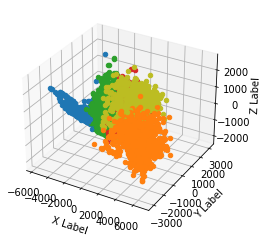

7996


In [ ]:
from scipy.io.wavfile import write
import random
from IPython.display import Audio, display
import torch
import numpy as np
from sklearn.cluster import KMeans

class DysarthriaDataset(Dataset):

    def __init__(self, root_dir):
        self.data = pd.read_csv(root_dir + '/data.csv')
        self.mat = []
        def preprocess(signal, sr, augument=False, visualize=False):
                if augument:
                    effects = [
                        ["speed", str(random.uniform(0.5, 1.5))],
                        ['pitch', str(random.uniform(-8,8))],
                        ["rate", f"{sr}"],
                    ]
                    signal, sr = torchaudio.sox_effects.apply_effects_tensor(signal, sr, effects)
                if sr != 16000:
                    resampler = torchaudio.transforms.Resample(sr, 16000)
                    signal = resampler(signal)
                if signal.shape[1] > 100000:
                    signal = signal[:, :100000]
                length_signal = signal.shape[1]
                if length_signal < 100000:
                    num_missing_samples = 100000 - length_signal
                    last_dim_padding = (0, num_missing_samples)
                    signal = torch.nn.functional.pad(signal, last_dim_padding)
                if visualize:
                  display(Audio(signal, rate=16000))
                mfcc = T.MFCC(sample_rate=16000, n_mfcc=64, melkwargs={"n_mels": 64})
                signal = mfcc(signal)
                if visualize:
                  plot_spectrogram(signal[0])
                return signal
 
        for index in range(2000):
            try:
                label = torch.tensor([1.0]) if self.data.iloc[index][0] == 'dysarthria' else torch.tensor([0.0])
                signal, sr = torchaudio.load('drive/MyDrive/' + self.data.iloc[index][2])
                #if label == torch.tensor([1.0]):
                  #samp1 = preprocess(signal, sr, visualize=True)
                  #samp2 = preprocess(signal, sr, augument=True, visualize=True)
                  #samp3 = preprocess(signal, sr, augument=True, visualize=True)
                  #samp4 = preprocess(signal, sr, augument=True, visualize=True)
                #else:
                samp1 = preprocess(signal, sr)
                samp2 = preprocess(signal, sr, augument=True)
                samp3 = preprocess(signal, sr, augument=True)
                samp4 = preprocess(signal, sr, augument=True)
                self.mat.append([samp1, label]), self.mat.append([samp2, label]), self.mat.append([samp3, label]), self.mat.append([samp4, label])
            except:
                print('A corrupt file was found')
        cluster_ids = self.get_severity_classes()
        n = 0
        for index in range(len(self.mat)):
          if torch.eq(self.mat[index][1], torch.tensor([1.0])):
            self.mat[index][1] = cluster_ids[n] + 1
            n = n + 1
        for index in range(len(self.mat)):
            t = torch.zeros((6))
            t[int(self.mat[index][1])] = 1
            self.mat[index][1] = t

    def __len__(self):
        return len(self.mat)

    def __getitem__(self, index):
        return self.mat[index][0], self.mat[index][1]

    def get_severity_classes(self):
        x = []
        for index in range(len(self.mat)):
          if torch.eq(self.mat[index][1], torch.tensor([1.])):
            x.append(self.mat[index][0].tolist())
        x = torch.tensor(x).detach().cpu().numpy()
        x = np.reshape(x, (x.shape[0], x.shape[1]*x.shape[2]*x.shape[3]))
        pca = PCA(n_components=25).fit(x)
        x = pca.transform(x)
        print('Variation Explained: ' + str(np.sum(pca.explained_variance_ratio_)))
        kmeans = KMeans(n_clusters=5, init='random', n_init=10, max_iter=300, tol=1e-04, random_state=0)
        kmeans.fit_predict(x)

        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
        print(len(kmeans.labels_))
        n = 100

        # For each set of style and range settings, plot n random points in the box
        # defined by x in [23, 32], y in [0, 100], z in [zlow, zhigh].
        for i in range(len(x)):
          m = x[i]
          if kmeans.labels_[i] == 0:
            ax.scatter(m[0], m[1], m[2], marker="o", c='#1f77b4')
          elif kmeans.labels_[i] == 1:
            ax.scatter(m[0], m[1], m[2], marker="o", c='#ff7f0e')
          elif kmeans.labels_[i] == 2:
            ax.scatter(m[0], m[1], m[2], marker="o", c='#2ca02c')
          elif kmeans.labels_[i] == 3:
            ax.scatter(m[0], m[1], m[2], marker="o", c='#bcbd22')
          elif kmeans.labels_[i] == 4:
            ax.scatter(m[0], m[1], m[2], marker="o", c='#d62728')
        ax.set_xlabel('X Label')
        ax.set_ylabel('Y Label')
        ax.set_zlabel('Z Label')

        plt.show()
        return kmeans.labels_

BATCH_SIZE = 128
EPOCHS = 200

if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
print(f"Using {device}")
data = DysarthriaDataset('drive/MyDrive/torgo_data')
print(len(data))


train_set, val_set, test_set = torch.utils.data.random_split(data, [7396,300, 300])
train_dataloader = DataLoader(train_set, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_set, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_set, batch_size=BATCH_SIZE, shuffle=True)

In [ ]:
input = torch.tensor([])
output = torch.tensor([])
for i in range(len(data)):
  mat, id = data.__getitem__(i)
  input = torch.cat((input, torch.unsqueeze(mat, dim=0)), dim=0)
  output = torch.cat((output, torch.unsqueeze(id, dim=0)), dim=0)

In [ ]:
torch.save(input, 'unsupInputs.pt')
torch.save(output, 'unsupLabels.pt')

Initializing training modules for CRNN

In [ ]:
LEARNING_RATE = 2e-2
# construct model and assign it to device
crnn = CRNN(6, 640, 20, 3, 33).cuda()
print(crnn)
# initialise loss funtion + optimiser
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(crnn.parameters(), lr=LEARNING_RATE)
from torch.optim.lr_scheduler import CosineAnnealingLR
scheduler = CosineAnnealingLR(optimizer,
                              T_max = 50, # Maximum number of iterations.
                             eta_min = 8e-4) # Minimum learning rate.
for param in crnn.parameters():
    param.requires_grad = True
# train model

CRNN(
  (conv1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv4): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(2, 2))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (lstm): LSTM(640, 20, num_layers=3, batch_first=True)
  (fc1): Linear(in_features=660, out_features=6, bias=True)
  (relu): ReLU()
)


Training crnn

In [ ]:
def calc_accuracy(mdl: torch.nn.Module, X: torch.Tensor, Y: torch.Tensor) -> float:
        predicted = mdl(X)
        correct = 0
        smax = nn.Softmax()
        predicted = smax(predicted)
        for i in range(len(X)):
          if torch.sum(torch.eq(Y[i], torch.round(predicted[i])).long()) == 6:
            correct = correct + 1
        return 100 * correct // len(X)

EPOCHS = 100
for i in range(EPOCHS):
    #try:
        print(f"Epoch {i+1}")
        train_loss = 0
        val_loss = 0
        train_acc = 0
        val_acc = 0
        n = 0
        for input, target in train_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = crnn(input)
            loss = loss_fn(prediction, target)
            train_loss = train_loss + (loss.item()*len(input))
            # backpropagate error and update weights
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_acc = train_acc + (len(input)*calc_accuracy(crnn, input, target))
            n = n + len(input)
        train_loss/=n
        train_acc/=n
        n = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = crnn(input)
            loss = loss_fn(prediction, target)
            val_loss = val_loss + (loss.item()*len(input))
            val_acc = val_acc + (len(input)*calc_accuracy(crnn, input, target))
            n = n + len(input)
        val_loss/=n
        val_acc/=n
        writer.add_scalar('CRNN_Loss/train', train_loss, i)
        writer.add_scalar('CRNN_Loss/validation', val_loss, i)
        writer.add_scalar('CRNN_Accuracy/train', train_acc, i)
        writer.add_scalar('CRNN_Accuracy/validation', val_acc, i)
        print(train_loss, val_loss, train_acc, val_acc)
        scheduler.step()
    #except:
    #  break
print("---------------------------")
print("Finished training")
# save model
torch.save(crnn.state_dict(), "crnnnetwork.pth")
print("Trained feed forward net saved at crnnnetwork.pth")

Epoch 1


<ipython-input-14-922dc3617190>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted = smax(predicted)


1.5366791189522793 1.4202788321177164 10.74959437533802 41.70666666666666
Epoch 2
1.4712026225611479 1.4214660008748372 31.99837750135208 6.466666666666667
Epoch 3
1.4479318468425002 1.3701232941945394 33.25419145484045 36.72
Epoch 4
1.4139924799835057 1.2852275387446086 36.41535965386696 44.666666666666664
Epoch 5
1.3655260804538922 1.2592292070388793 37.914007571660356 48.12
Epoch 6
1.3395591825327402 1.1801172240575155 37.19307733910222 47.093333333333334
Epoch 7
1.2752241677629297 1.1332238419850666 38.9848566792861 49.6
Epoch 8
1.238553064200864 1.1050039529800415 39.12655489453759 43.333333333333336
Epoch 9
1.169713707277103 1.1574543491999307 40.80475932936722 51.653333333333336
Epoch 10
1.1620404684201906 0.9588477126757304 37.93564088696593 49.48
Epoch 11
1.0309203893768266 0.9053124237060547 40.80800432666306 48.10666666666667
Epoch 12
0.9972322391393443 0.9573141105969747 41.12276906435911 36.973333333333336
Epoch 13
0.9934408656321969 0.8294128092130025 43.22714981070849 53

KeyboardInterrupt: ignored

Evaluating crnn

In [ ]:
def evaluate_model(model):
        n = 0
        val_loss = 0
        val_acc = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            val_loss = val_loss + (loss.item()*len(input))
            val_acc = val_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        val_loss/=n
        val_acc/=n
        n = 0
        train_loss = 0
        train_acc = 0
        for input, target in train_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            train_loss = train_loss + (loss.item()*len(input))
            train_acc = train_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        train_loss/=n
        train_acc/=n
        n = 0
        test_loss = 0
        test_acc = 0
        for input, target in val_dataloader:
            input, target = input.to(device), target.to(device)
            # calculate loss
            prediction = model(input)
            loss = loss_fn(prediction, target)
            test_loss = test_loss + (loss.item()*len(input))
            test_acc = test_acc + (len(input)*calc_accuracy(model, input, target))
            n = n + len(input)
        test_loss/=n
        test_acc/=n
        print(train_loss, train_acc, val_loss, val_acc, test_loss, test_acc)
print('CRNN results: ')
evaluate_model(crnn)

CRNN results: 


<ipython-input-106-922dc3617190>:5: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  predicted = smax(predicted)


0.16347073532717496 93.20010816657653 0.25558602770169575 88.42666666666666 0.25558609565099083 88.73333333333333


In [ ]:
writer.close()

In [ ]:
#!pip install torch torchvision
#!pip install tensorboard
!tensorboard --logdir=my_dir

2023-03-05 10:47:51.944234: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-05 10:47:51.944316: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-03-05 10:47:51.944330: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflo